# Investigate the Quality of Imagenette

In [1]:
!pip install selfclean -Uq
!pip freeze | grep selfclean

selfclean==0.0.17


In [2]:
try:
    import google.colab

    IN_COLAB = True
except:
    IN_COLAB = False

import os

IN_KAGGLE = "KAGGLE_KERNEL_RUN_TYPE" in os.environ

In [3]:
import torch
from torchvision import datasets, transforms
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import copy
import sys

from selfclean import SelfClean
from selfclean.cleaner.selfclean import PretrainingType

if IN_COLAB or IN_KAGGLE:
    !git clone https://github.com/Digital-Dermatology/data-cleaning-hands-on.git
    sys.path.append("data-cleaning-hands-on")
else:
    sys.path.append("../")

from src.ssl_library.src.utils.data_downloading import get_imagenette

In [4]:
if IN_COLAB or IN_KAGGLE:
    pre_computed_path = Path("data-cleaning-hands-on/assets/pre_trained_models")
else:
    pre_computed_path = Path("../assets/pre_trained_models")

We start by downloading our dataset to analyze.

In [5]:
dataset_name = "ImageNette"
data_path = Path("../data/")
dataset, df = get_imagenette(
   root_path=data_path, return_dataframe=True, transform=transforms.Resize((256, 256))
)

dataset

ImageNette already downloaded to `../data`.


Dataset ImageFolder
    Number of datapoints: 13394
    Root location: ../data/imagenette2-160
    StandardTransform
Transform: Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=None)

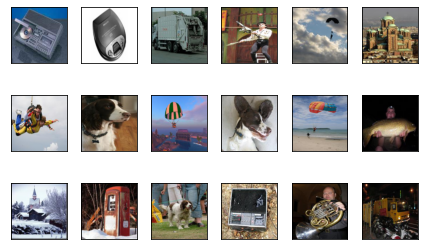

In [6]:
fig, axes = plt.subplots(3, 6)
for h_idx, h_ax in enumerate(axes):
    for v_idx, ax in enumerate(h_ax):
        index = np.random.randint(0, high=len(dataset))
        ax.imshow(dataset[index][0])
        ax.set_xticks([])
        ax.set_yticks([])
        index += 1
fig.tight_layout()
plt.show()

As a first step, SelfClean will train a model using self-supervised learning on the provided dataset. 
Afterwards, it will use the learned representations to detect data quality issues using simple scoring functions.

Self-supervised pre-training can take some time, so we set the number of pre-training epochs here to `10`. However, we suggest letting it run for longer to achieve optimal performance.

Here, we have already carried out the SSL pre-training to speed things up.

In [7]:
selfclean = SelfClean(
    plot_top_N=7,
    auto_cleaning=True,
)

2024-04-04 08:46:40.401 | INFO     | Running on: cuda
2024-04-04 08:46:47.032 | INFO     | Found checkpoint at ../assets/pre_trained_models/DINO-ImageNette/checkpoints/model_best.pth


Creating dataset representation:   0%|          | 0/838 [00:00<?, ?it/s]

Creating distance matrix:   0%|          | 0/134 [00:00<?, ?it/s]

Processing possible near duplicates:   0%|          | 0/8970 [00:00<?, ?it/s]

Processing possible irrelevant samples: 0it [00:00, ?it/s]

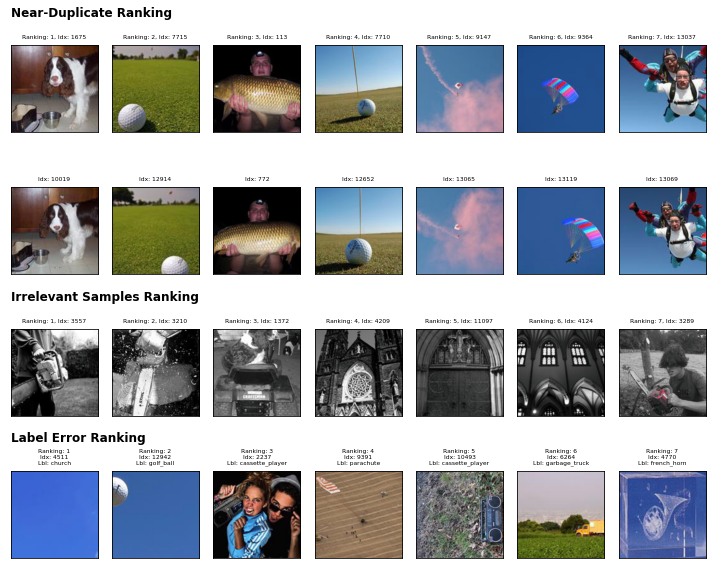

In [8]:
issues = selfclean.run_on_dataset(
    dataset=copy.copy(dataset),
    pretraining_type=PretrainingType.DINO,
    epochs=10,
    batch_size=16,
    save_every_n_epochs=1,
    dataset_name=dataset_name,
    work_dir=pre_computed_path,
)

Let's look at each issue type in more detail.

In [9]:
# reset to our visualisation augmentation
dataset.transforms = None

### Near duplicates

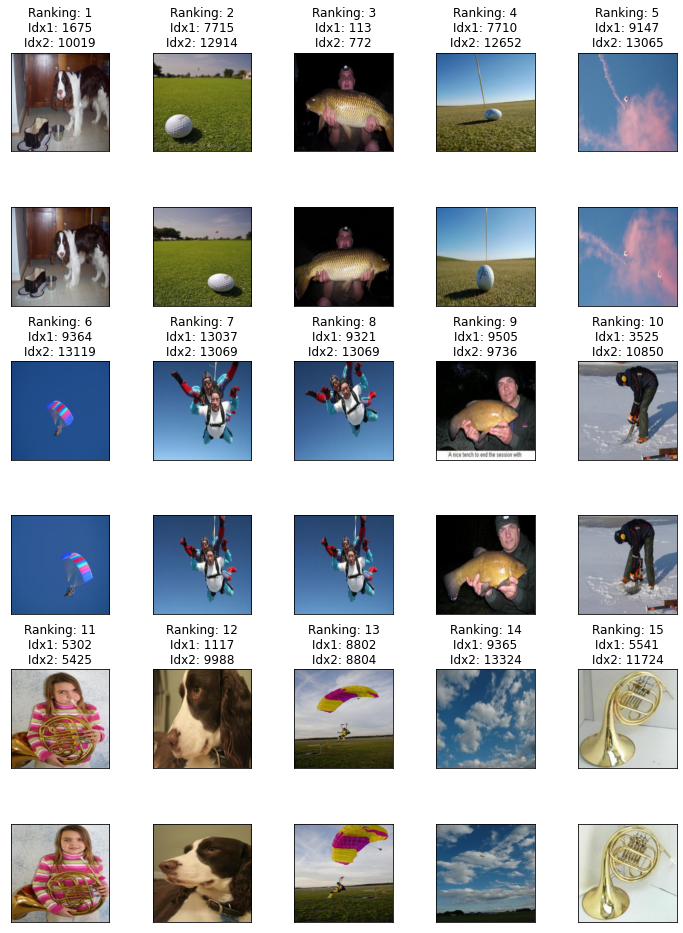

In [10]:
r_index = 0
fig, axes = plt.subplots(6, 5, figsize=(10, 13))
for h_idx, h_ax in enumerate(axes):
    for v_idx, ax in enumerate(h_ax):
        if h_idx % 2 == 1:
            continue

        idx1, idx2 = issues.get_issues('near_duplicates')['indices'][r_index]
        idx1, idx2 = int(idx1), int(idx2)

        ax.imshow(dataset[idx1][0])
        axes[h_idx + 1, v_idx].imshow(dataset[idx2][0])
        ax.set_title(
            f"Ranking: {r_index+1}"
            f"\nIdx1: {idx1}"
            f"\nIdx2: {idx2}"
        )
        ax.set_xticks([])
        ax.set_yticks([])
        axes[h_idx + 1, v_idx].set_xticks([])
        axes[h_idx + 1, v_idx].set_yticks([])
        r_index += 1

fig.tight_layout()
plt.show()

In [11]:
df_near_duplicates = issues.get_issues("near_duplicates", return_as_df=True)
df_near_duplicates.head()

2024-04-04 08:50:19.851 | WARNING  | Returning as dataframe requires extensive memory.


,indices_1,indices_2,scores,auto_issues,label_indices_1,label_indices_2
0,1675,10019,0.018143,False,english_springer,english_springer
1,7715,12914,0.021281,False,golf_ball,golf_ball
2,113,772,0.022048,False,tench,tench
3,7710,12652,0.022663,False,golf_ball,golf_ball
4,9147,13065,0.022777,False,parachute,parachute


### Irrelevant Samples

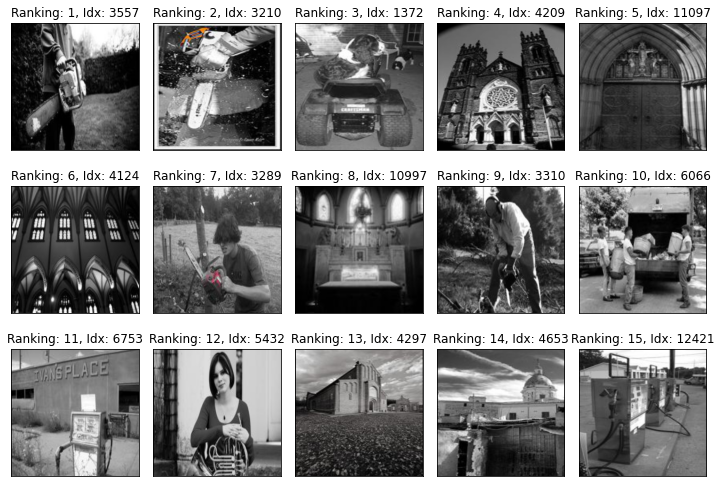

In [12]:
r_index = 0
fig, axes = plt.subplots(3, 5, figsize=(10, 7))
for h_ax in axes:
    for ax in h_ax:
        idx = issues.get_issues('irrelevants')['indices'][r_index]
        ax.imshow(dataset[idx][0])
        ax.set_title(f"Ranking: {r_index+1}, Idx: {idx}")
        ax.set_xticks([])
        ax.set_yticks([])
        r_index += 1
fig.tight_layout()
plt.show()

In [13]:
df_irrelevants = issues.get_issues("irrelevants", return_as_df=True)
df_irrelevants.head()

2024-04-04 08:50:44.778 | WARNING  | Returning as dataframe requires extensive memory.


,indices,scores,auto_issues,label
0,3557,0.735495,False,chain_saw
1,3210,0.738859,False,chain_saw
2,1372,0.743306,False,english_springer
3,4209,0.745973,False,church
4,11097,0.747956,False,church


### Label Errors

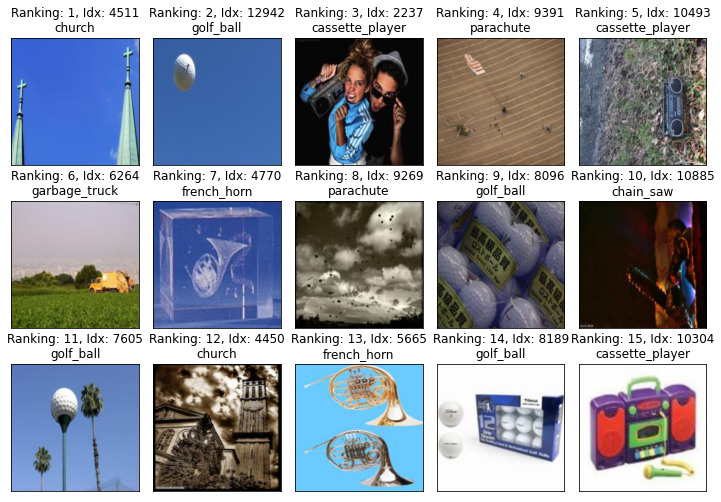

In [14]:
r_index = 0
fig, axes = plt.subplots(3, 5, figsize=(10, 7))
for h_ax in axes:
    for ax in h_ax:
        idx = issues.get_issues('label_errors')['indices'][r_index]
        ax.imshow(dataset[idx][0])
        ax.set_title(
            f"Ranking: {r_index+1}, Idx: {idx}"
            f"\n{dataset.classes[dataset[idx][1]]}"
        )
        ax.set_xticks([])
        ax.set_yticks([])
        r_index += 1
fig.tight_layout()
plt.show()

In [15]:
df_label_errors = issues.get_issues("label_errors", return_as_df=True)
df_label_errors.head()

2024-04-04 08:50:45.276 | WARNING  | Returning as dataframe requires extensive memory.


,indices,scores,auto_issues,label
0,4511,0.110151,True,church
1,12942,0.157332,True,golf_ball
2,2237,0.165419,True,cassette_player
3,9391,0.167526,True,parachute
4,10493,0.173684,True,cassette_player
